In [79]:
from rag.embeddings import LocalEmbedder
from rag.ingestion.chunker import SemanticChunker
%load_ext autoreload
%autoreload 2

from rag.config import settings

embedder = LocalEmbedder(settings.embedding_model)
embedder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


LocalEmbedder("BAAI/bge-small-en-v1.5", dim=384)

In [16]:
from rag.utils import get_token_counter
from langchain_text_splitters import SpacyTextSplitter, RecursiveCharacterTextSplitter

splitter = SpacyTextSplitter(
            chunk_size=64,
            chunk_overlap=0,
            length_function=get_token_counter(settings.embedding_model),
            pipeline="en_core_web_sm",
            # pipeline="en_core_sci_sm",
)

# splitter = RecursiveCharacterTextSplitter(
#     chunk_size=50,  # Small enough to avoid merging
#     chunk_overlap=0,
#     separators=[". ", ".\n", "; "],  # Split on periods/semicolons
#     length_function=get_token_counter(settings.embedding_model),
# )
#
splitter

In [17]:
text = """P.aeruginosa isolates from ICU patients demonstrated resistance to carbapenem antibiotics; specifically, MIC values for meropenem exceeded 16 μg/mL, indicating severe β-lactam resistance mediated by OprD porin loss. The E.coli strain harbored multiple ESBL genes (blaCTX-M-15, blaTEM-1), conferring resistance to third-generation cephalosporins; PCR amplification confirmed plasmid-mediated horizontal gene transfer via conjugation. Vancomycin-resistant Enterococcus faecium (VRE) exhibits the vanA gene cluster, which modifies peptidoglycan precursors from D-Ala-D-Ala to D-Ala-D-Lac, reducing vancomycin binding affinity by ~1000-fold. Alzheimer's disease pathology involves hyperphosphorylated tau protein forming neurofibrillary tangles (NFTs); phosphorylation at Ser202/Thr205 (AT8 epitope) disrupts microtubule stabilization, leading to axonal transport deficits. α-synuclein aggregation in Parkinson's disease creates Lewy bodies within dopaminergic neurons; the A53T mutation accelerates oligomerization kinetics, with fibrils exhibiting cross-β sheet structures detectable via thioflavin-T fluorescence assays."""

In [60]:
chunks = splitter.split_text(text)
for c in chunks:
    print(c)
    print("="*80)

/home/ergot/projects/rag/.venv/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Created a chunk of size 65, which is longer than the specified 64
Created a chunk of size 66, which is longer than the specified 64


P.aeruginosa isolates from ICU patients demonstrated resistance to carbapenem antibiotics; specifically, MIC values for meropenem exceeded 16 μg/mL, indicating severe β-lactam resistance mediated by OprD porin loss.
The E.coli strain harbored multiple ESBL genes (blaCTX-M-15, blaTEM-1), conferring resistance to third-generation cephalosporins; PCR amplification confirmed plasmid-mediated horizontal gene transfer via conjugation.
Vancomycin-resistant Enterococcus faecium (VRE) exhibits the vanA gene cluster, which modifies peptidoglycan precursors from D-Ala-D-Ala to D-Ala-D-Lac, reducing vancomycin binding affinity by ~1000-fold.
Alzheimer's disease pathology involves hyperphosphorylated tau protein forming neurofibrillary tangles (NFTs); phosphorylation at Ser202/Thr205 (AT8 epitope) disrupts microtubule stabilization, leading to axonal transport deficits.
α-synuclein aggregation in Parkinson's disease creates Lewy bodies within dopaminergic neurons; the A53T mutation accelerates olig

<Axes: >

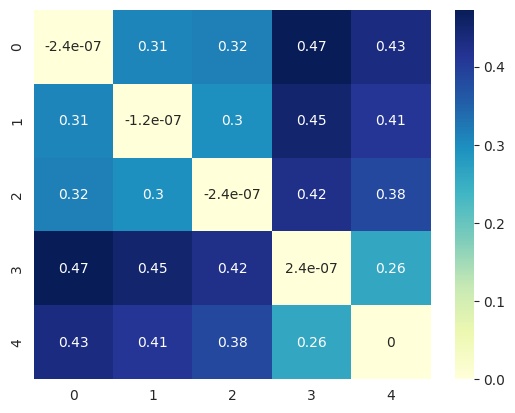

In [63]:
import seaborn as sns

embs = embedder.embed_batch(chunks)
dist = 1 - embs.dot(embs.T)
sns.heatmap(dist, annot=True, cmap="YlGnBu")

In [36]:
import sklearn

sklearn.metrics.pairwise_distances

<function sklearn.metrics.pairwise.pairwise_distances(X, Y=None, metric='euclidean', *, n_jobs=None, force_all_finite='deprecated', ensure_all_finite=None, **kwds)>

In [64]:
from sklearn.cluster import DBSCAN

cls = DBSCAN(eps=0.35, min_samples=1, metric="cosine")
labels = cls.fit_predict(embs)
labels

array([0, 0, 0, 1, 1])

In [65]:
import numpy as np

unique_labels = np.unique(labels)
unique_labels

array([0, 1])

In [66]:
mask = labels == unique_labels[:, np.newaxis]
mask

array([[ True,  True,  True, False, False],
       [False, False, False,  True,  True]])

In [70]:
mask.shape

(2, 5)

In [77]:
chunks_arr = np.array(chunks)
chunks_clustered = ["".join(chunks_arr[row]) for row in mask]

['P.aeruginosa isolates from ICU patients demonstrated resistance to carbapenem antibiotics; specifically, MIC values for meropenem exceeded 16 μg/mL, indicating severe β-lactam resistance mediated by OprD porin loss.The E.coli strain harbored multiple ESBL genes (blaCTX-M-15, blaTEM-1), conferring resistance to third-generation cephalosporins; PCR amplification confirmed plasmid-mediated horizontal gene transfer via conjugation.Vancomycin-resistant Enterococcus faecium (VRE) exhibits the vanA gene cluster, which modifies peptidoglycan precursors from D-Ala-D-Ala to D-Ala-D-Lac, reducing vancomycin binding affinity by ~1000-fold.',
 "Alzheimer's disease pathology involves hyperphosphorylated tau protein forming neurofibrillary tangles (NFTs); phosphorylation at Ser202/Thr205 (AT8 epitope) disrupts microtubule stabilization, leading to axonal transport deficits.α-synuclein aggregation in Parkinson's disease creates Lewy bodies within dopaminergic neurons; the A53T mutation accelerates o

In [81]:
chunker = SemanticChunker(
    threshold=0.35,
    chunk_size=64,
    chunk_overlap=0,
    embedder_model=settings.embedding_model,
)
chunker

/home/ergot/projects/rag/.venv/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [82]:
chunker.chunk_text(text)

/home/ergot/projects/rag/.venv/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Created a chunk of size 65, which is longer than the specified 64
Created a chunk of size 66, which is longer than the specified 64


['P.aeruginosa isolates from ICU patients demonstrated resistance to carbapenem antibiotics; specifically, MIC values for meropenem exceeded 16 μg/mL, indicating severe β-lactam resistance mediated by OprD porin loss. The E.coli strain harbored multiple ESBL genes (blaCTX-M-15, blaTEM-1), conferring resistance to third-generation cephalosporins; PCR amplification confirmed plasmid-mediated horizontal gene transfer via conjugation. Vancomycin-resistant Enterococcus faecium (VRE) exhibits the vanA gene cluster, which modifies peptidoglycan precursors from D-Ala-D-Ala to D-Ala-D-Lac, reducing vancomycin binding affinity by ~1000-fold.',
 "Alzheimer's disease pathology involves hyperphosphorylated tau protein forming neurofibrillary tangles (NFTs); phosphorylation at Ser202/Thr205 (AT8 epitope) disrupts microtubule stabilization, leading to axonal transport deficits. α-synuclein aggregation in Parkinson's disease creates Lewy bodies within dopaminergic neurons; the A53T mutation accelerate